# Battle of the Neighborhoods, City of Chicago, Best Italian Restaurant Locations

### Table of Content

## A. Introduction

This project is aimed towards pizza place owners in City of Chicago in order to explore what features successful neighborhoods for pizza place have and if there are any potential neighborhoods with similar feature and without any current pizza place venues that would be make a viable option to explore business in.

## B. Data

### 1) Chicago neighborhood location

We found a wikipage'https://en.wikipedia.org/wiki/Community_areas_in_Chicago' lists all the community areas in Chicao and its population of 2017.
we will read the community table to a panda dataframe

Geopy https://geopy.readthedocs.io/en/stable/ is a python library which enables geographic coordinates to be attained from addresses, cities, countries, and landmarks. This library will be utilized in order to coordinates of each of the Arlington neighborhoods.

### 2) Chicago community income per capita

City of Chicago data portal provides a dataset for contains a selection of six socioeconomic indicators of public health significance and a “hardship index,” by Chicago community area, for the years 2008 – 2012. We will use the income per capita for each neighborhood for our analysis
https://data.cityofchicago.org/Health-Human-Services/Census-Data-Selected-socioeconomic-indicators-in-C/kn9c-c2s2

### 3) Four Square Venue Data

Four Square https://foursquare.com is a social networking service which provides an API with a feature that allows developers to find information about venues listed in their data that are nearby geographic coordinates. The API will be used to find venues that are nearby each neighborhood in Arlington in order provide data on the venue composition of them.

## C. Methodology

### 1. Import libaries and necessary package

In [233]:
# import libaries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup #webscrapping
import json # library to handle jason file
import requests
from pandas.io.json import json_normalize
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.exc import GeocoderTimedOut
from sklearn.preprocessing import MinMaxScaler

# import plot
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

#import folium map
! pip install folium==0.5.0
import folium

## import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


### 2. Preprocessing and acquire the data

### 2.1 Obtain Chicago neighborhood data from wiki webpage

In [234]:
# define url
url = 'https://en.wikipedia.org/wiki/Community_areas_in_Chicago'

In [235]:
table = pd.read_html(url)
print(table[0])

   Number[8]          Name[8]  2017[9] Area (sq mi.)[10]  Area (km2)  \
0         01      Rogers Park    55062              1.84        4.77   
1         02       West Ridge    76215              3.53        9.14   
2         03           Uptown    57973              2.32        6.01   
3         04   Lincoln Square    41715              2.56        6.63   
4         05     North Center    35789              2.05        5.31   
..       ...              ...      ...               ...         ...   
73        74  Mount Greenwood    19277              2.71        7.02   
74        75      Morgan Park    22394              3.30        8.55   
75        76           O'Hare    12377             13.34       34.55   
76        77        Edgewater    55965              1.74        4.51   
77     Total          Chicago  2722586        227.34[12]      588.81   

    2017density (/sq mi.)  2017density (/km2)  
0                29925.00            11554.11  
1                21590.65             8

In [236]:
data=pd.DataFrame(table[0])
data.head(5)

,Number[8],Name[8],2017[9],Area (sq mi.)[10],Area (km2),2017density (/sq mi.),2017density (/km2)
0,01,Rogers Park,55062,1.84,4.77,29925.00,11554.11
1,02,West Ridge,76215,3.53,9.14,21590.65,8336.20
2,03,Uptown,57973,2.32,6.01,24988.36,9648.06
3,04,Lincoln Square,41715,2.56,6.63,16294.92,6291.50
4,05,North Center,35789,2.05,5.31,17458.05,6740.59


### 2.2 Clean the dataset to keep only the name of the neighborhood and population

In [237]:
data = data.drop(['Number[8]','Area (sq mi.)[10]','Area (km2)','2017density (/sq mi.)','2017density (/km2)'],1)
data.rename(columns={'Name[8]':'Neighborhood','2017[9]':'2017 Population'},inplace=True)

In [238]:
#drop the Chicago row 
data.drop([77,1],inplace=True)

In [239]:
# check the result
data.tail()

,Neighborhood,2017 Population
72,Washington Heights,27453
73,Mount Greenwood,19277
74,Morgan Park,22394
75,O'Hare,12377
76,Edgewater,55965


In [240]:
# save the dataframe to cvs
data.to_csv('Chicago.csv')

In [241]:
chicago_data=pd.read_csv('Chicago.csv')

In [242]:
chicago_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       76 non-null     int64 
 1   Neighborhood     76 non-null     object
 2   2017 Population  76 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ KB


### 2.3 Getting geocoordinates of each community in Chicago, IL

In [243]:
# declare an empty list to store latitude and longitude of values 
latitude=[]
longitude=[]

# define a function to find the coordinate of a given neighborhood 

def findGeocode(neigh):
    try:
        address = neigh + ', Chicago,IL'
        geolocator = Nominatim(user_agent="my_explorer")
        location=geolocator.geocode(address)
        return location
    except GeocoderTimedOut:
        return location
        
    
   # each value from the neighborhood column will be fetched and sent to function find_geocode

for i in (chicago_data["Neighborhood"]):
    if findGeocode(i)!= None:
        loc = findGeocode(i)
                
        # coordinates returned from function is stored into two separate list
        latitude.append(loc.latitude)
        longitude.append(loc.longitude)
        
        # if coordinate for a city not found, insert "NaN" indicating missing value
    else:
        latitude.append(np.nan)
        longitude.append(np.nan)
            
# add the two columns to the dataframe
chicago_data["Latitude"]=latitude
chicago_data["Longitude"]=longitude

chicago_data.head()

,Unnamed: 0,Neighborhood,2017 Population,Latitude,Longitude
0,0,Rogers Park,55062,42.009037,-87.676849
1,2,Uptown,57973,41.966630,-87.655546
2,3,Lincoln Square,41715,41.968512,-87.688653
3,4,North Center,35789,41.956107,-87.679160
4,5,Lake View,100470,41.943919,-87.654076


In [244]:
#drop the column unnamed:0
chicago_data.drop(['Unnamed: 0'],1,inplace=True)
chicago_data.head()

,Neighborhood,2017 Population,Latitude,Longitude
0,Rogers Park,55062,42.009037,-87.676849
1,Uptown,57973,41.966630,-87.655546
2,Lincoln Square,41715,41.968512,-87.688653
3,North Center,35789,41.956107,-87.679160
4,Lake View,100470,41.943919,-87.654076


In [245]:
# check if there is any empty value
print(chicago_data.isnull().sum())
chicago_data[chicago_data.isna().any(axis=1)]

Neighborhood       0
2017 Population    0
Latitude           1
Longitude          1
dtype: int64


,Neighborhood,2017 Population,Latitude,Longitude
30,(The) Loop[11],35880,NaN,NaN


In [246]:
# correct the name of 'The Loop'
chicago_data.loc[30:30,['Neighborhood']]='The Loop'
chicago_data.loc[30:35,:]

,Neighborhood,2017 Population,Latitude,Longitude
30,The Loop,35880,NaN,NaN
31,Near South Side,23620,41.856700,-87.624774
32,Armour Square,13455,41.840231,-87.632986
33,Douglas,20781,41.834868,-87.618013
34,Oakland,6645,41.823614,-87.605635
35,Fuller Park,2439,41.818089,-87.632551


In [247]:
# fill the missing geo code for The Loop

location_patches = [
['The Loop', 41.8816094, -87.6294574]]

for l in location_patches:
    chicago_data.loc[(chicago_data.Neighborhood == l[0]), ['Latitude', 'Longitude']] = l[1:]
chicago_data.loc[30:30,:]

,Neighborhood,2017 Population,Latitude,Longitude
30,The Loop,35880,41.881609,-87.629457


In [248]:
# double check if any empty value
chicago_data.isnull().sum()
chicago_data[chicago_data.isna().any(axis=1)]

,Neighborhood,2017 Population,Latitude,Longitude


### 3 Use the FourSquare API to find Pizza Place nearby each of the neighborhood

#### 3.1 Define Foursquare crentendials and version

In [249]:
# define Foursquare crentendials and version

CLIENT_ID = 'BYROLXJS0MTRA4BZHPR1Z044YFQN22H2NXGT45EJGVWJCQMV' # your Foursquare ID
CLIENT_SECRET = 'TU2MHFVOVAFLVE12T4CB2SNZYBD2R15NHGF1GYLHKZUCENTX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BYROLXJS0MTRA4BZHPR1Z044YFQN22H2NXGT45EJGVWJCQMV
CLIENT_SECRET:TU2MHFVOVAFLVE12T4CB2SNZYBD2R15NHGF1GYLHKZUCENTX


#### 3.2 Get Goercooridate of Chicago, IL

In [250]:
address = 'Chicago,IL'

geolocator = Nominatim(user_agent="Foursquare_agent")
location = geolocator.geocode(address)
chicago_latitude = location.latitude
chicago_longitude = location.longitude
print('Chicago Geographical coordinates are Lat={}, Lng={} '.format(chicago_latitude, chicago_longitude))

Chicago Geographical coordinates are Lat=41.8755616, Lng=-87.6244212 


#### 3.3 Function to fetch nearby Venue from FourSquare

In [251]:
def getNearbyVenues (names, latitude, longitude, radius=2000, limit=100):
    
    venue_lst=[] # initialize empty list
    
    for name, lat, lng in zip (names, latitude, longitude):
        print(name)
        
    
        # Foursuare API explore generated per Neighbourhood lat / lng passed from toronto_df
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
        
        # Get request
        results = requests.get(url).json()["response"]['groups'][0]['items']
                
        # return only relevant information for each nearby venue in the preliminary list
        venue_lst.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    venue_df = pd.DataFrame([item for venue_lst in venue_lst for item in venue_lst])
    venue_df.columns = ['Neighborhood', 
                  'Neighborhood Lat', 
                  'Neighborhood Lng', 
                  'Venue', 
                  'Venue Lat', 
                  'Venue Lng', 
                  'Venue Category']

    print('{} venues were returned by Foursquare.'.format(venue_df.shape[0]))
    
    return (venue_df)

In [252]:
chicago_venues_df = getNearbyVenues (names=chicago_data['Neighborhood'], 
                                     latitude=chicago_data['Latitude'], 
                                     longitude=chicago_data['Longitude'])

Rogers Park
Uptown
Lincoln Square
North Center
Lake View
Lincoln Park
Near North Side
Edison Park
Norwood Park
Jefferson Park
Forest Glen
North Park
Albany Park
Portage Park
Irving Park
Dunning
Montclare
Belmont Cragin
Hermosa
Avondale
Logan Square
Humboldt Park
West Town
Austin
West Garfield Park
East Garfield Park
Near West Side
North Lawndale
South Lawndale
Lower West Side
The Loop
Near South Side
Armour Square
Douglas
Oakland
Fuller Park
Grand Boulevard
Kenwood
Washington Park
Hyde Park
Woodlawn
South Shore
Chatham
Avalon Park
South Chicago
Burnside
Calumet Heights
Roseland
Pullman
South Deering
East Side
West Pullman
Riverdale
Hegewisch
Garfield Ridge
Archer Heights
Brighton Park
McKinley Park
Bridgeport
New City
West Elsdon
Gage Park
Clearing
West Lawn
Chicago Lawn
West Englewood
Englewood
Greater Grand Crossing
Ashburn
Auburn Gresham
Beverly Hills
Washington Heights
Mount Greenwood
Morgan Park
O'Hare
Edgewater
6472 venues were returned by Foursquare.


In [253]:
print(chicago_venues_df.shape)
chicago_venues_df.head()

(6472, 7)


,Neighborhood,Neighborhood Lat,Neighborhood Lng,Venue,Venue Lat,Venue Lng,Venue Category
0,Rogers Park,42.009037,-87.676849,El Famous Burrito,42.010421,-87.674204,Mexican Restaurant
1,Rogers Park,42.009037,-87.676849,Bark Place,42.010080,-87.675223,Pet Store
2,Rogers Park,42.009037,-87.676849,Mind Crusher Tattoo,42.003801,-87.672525,Tattoo Parlor
3,Rogers Park,42.009037,-87.676849,Taqueria & Restaurant Cd. Hidalgo,42.011634,-87.674484,Mexican Restaurant
4,Rogers Park,42.009037,-87.676849,Cermak Fresh Market,42.002812,-87.679381,Market


In [254]:
print('There are {} uniques venue categories.'.format(len(chicago_venues_df['Venue Category'].unique())))

There are 341 uniques venue categories.


### 4 Get data frame of Pizza Place venues nearby neighborhoods

In [255]:
nearby_Pizza = chicago_venues_df[chicago_venues_df['Venue Category'] == 'Pizza Place']
nearby_Pizza.head()

,Neighborhood,Neighborhood Lat,Neighborhood Lng,Venue,Venue Lat,Venue Lng,Venue Category
25,Rogers Park,42.009037,-87.676849,J.B. Alberto's Pizza,42.007941,-87.665066,Pizza Place
32,Rogers Park,42.009037,-87.676849,Candlelite Chicago Restaurant,42.017512,-87.690353,Pizza Place
33,Rogers Park,42.009037,-87.676849,Giordano's,42.006576,-87.661511,Pizza Place
39,Rogers Park,42.009037,-87.676849,Blaze Pizza,42.001625,-87.661102,Pizza Place
88,Rogers Park,42.009037,-87.676849,Villa Palermo Pizza,41.997800,-87.684708,Pizza Place


Map of Chicago with Pizza Place Superimposed

In [256]:
map_Pizza_Place = folium.Map(location=[chicago_latitude, chicago_longitude], zoom_start=12)

for lat, lng, venue in zip(nearby_Pizza['Venue Lat'], nearby_Pizza['Venue Lng'], nearby_Pizza['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Pizza_Place)
    

map_Pizza_Place

Count the Number of Italian Restaurant Near Neighborhood

In [257]:
nearby_pizza_count = nearby_Pizza.groupby('Neighborhood').agg({'Venue':'count'}).rename(columns={'Venue':'Pizza Place Count'})
nearby_pizza_count

,Pizza Place Count
Neighborhood,
Albany Park,3
Archer Heights,4
Armour Square,4
Ashburn,3
Auburn Gresham,1
...,...
West Elsdon,6
West Lawn,5
West Pullman,1


### 5. Explore nearby Venue categories

In [258]:
chicago_venues_df['Venue Category'].value_counts()

Mexican Restaurant      279
Sandwich Place          259
Pizza Place             235
Park                    228
Fast Food Restaurant    200
                       ... 
Memorial Site             1
Pakistani Restaurant      1
IT Services               1
Creperie                  1
Bike Trail                1
Name: Venue Category, Length: 341, dtype: int64

Visualize the venues categories

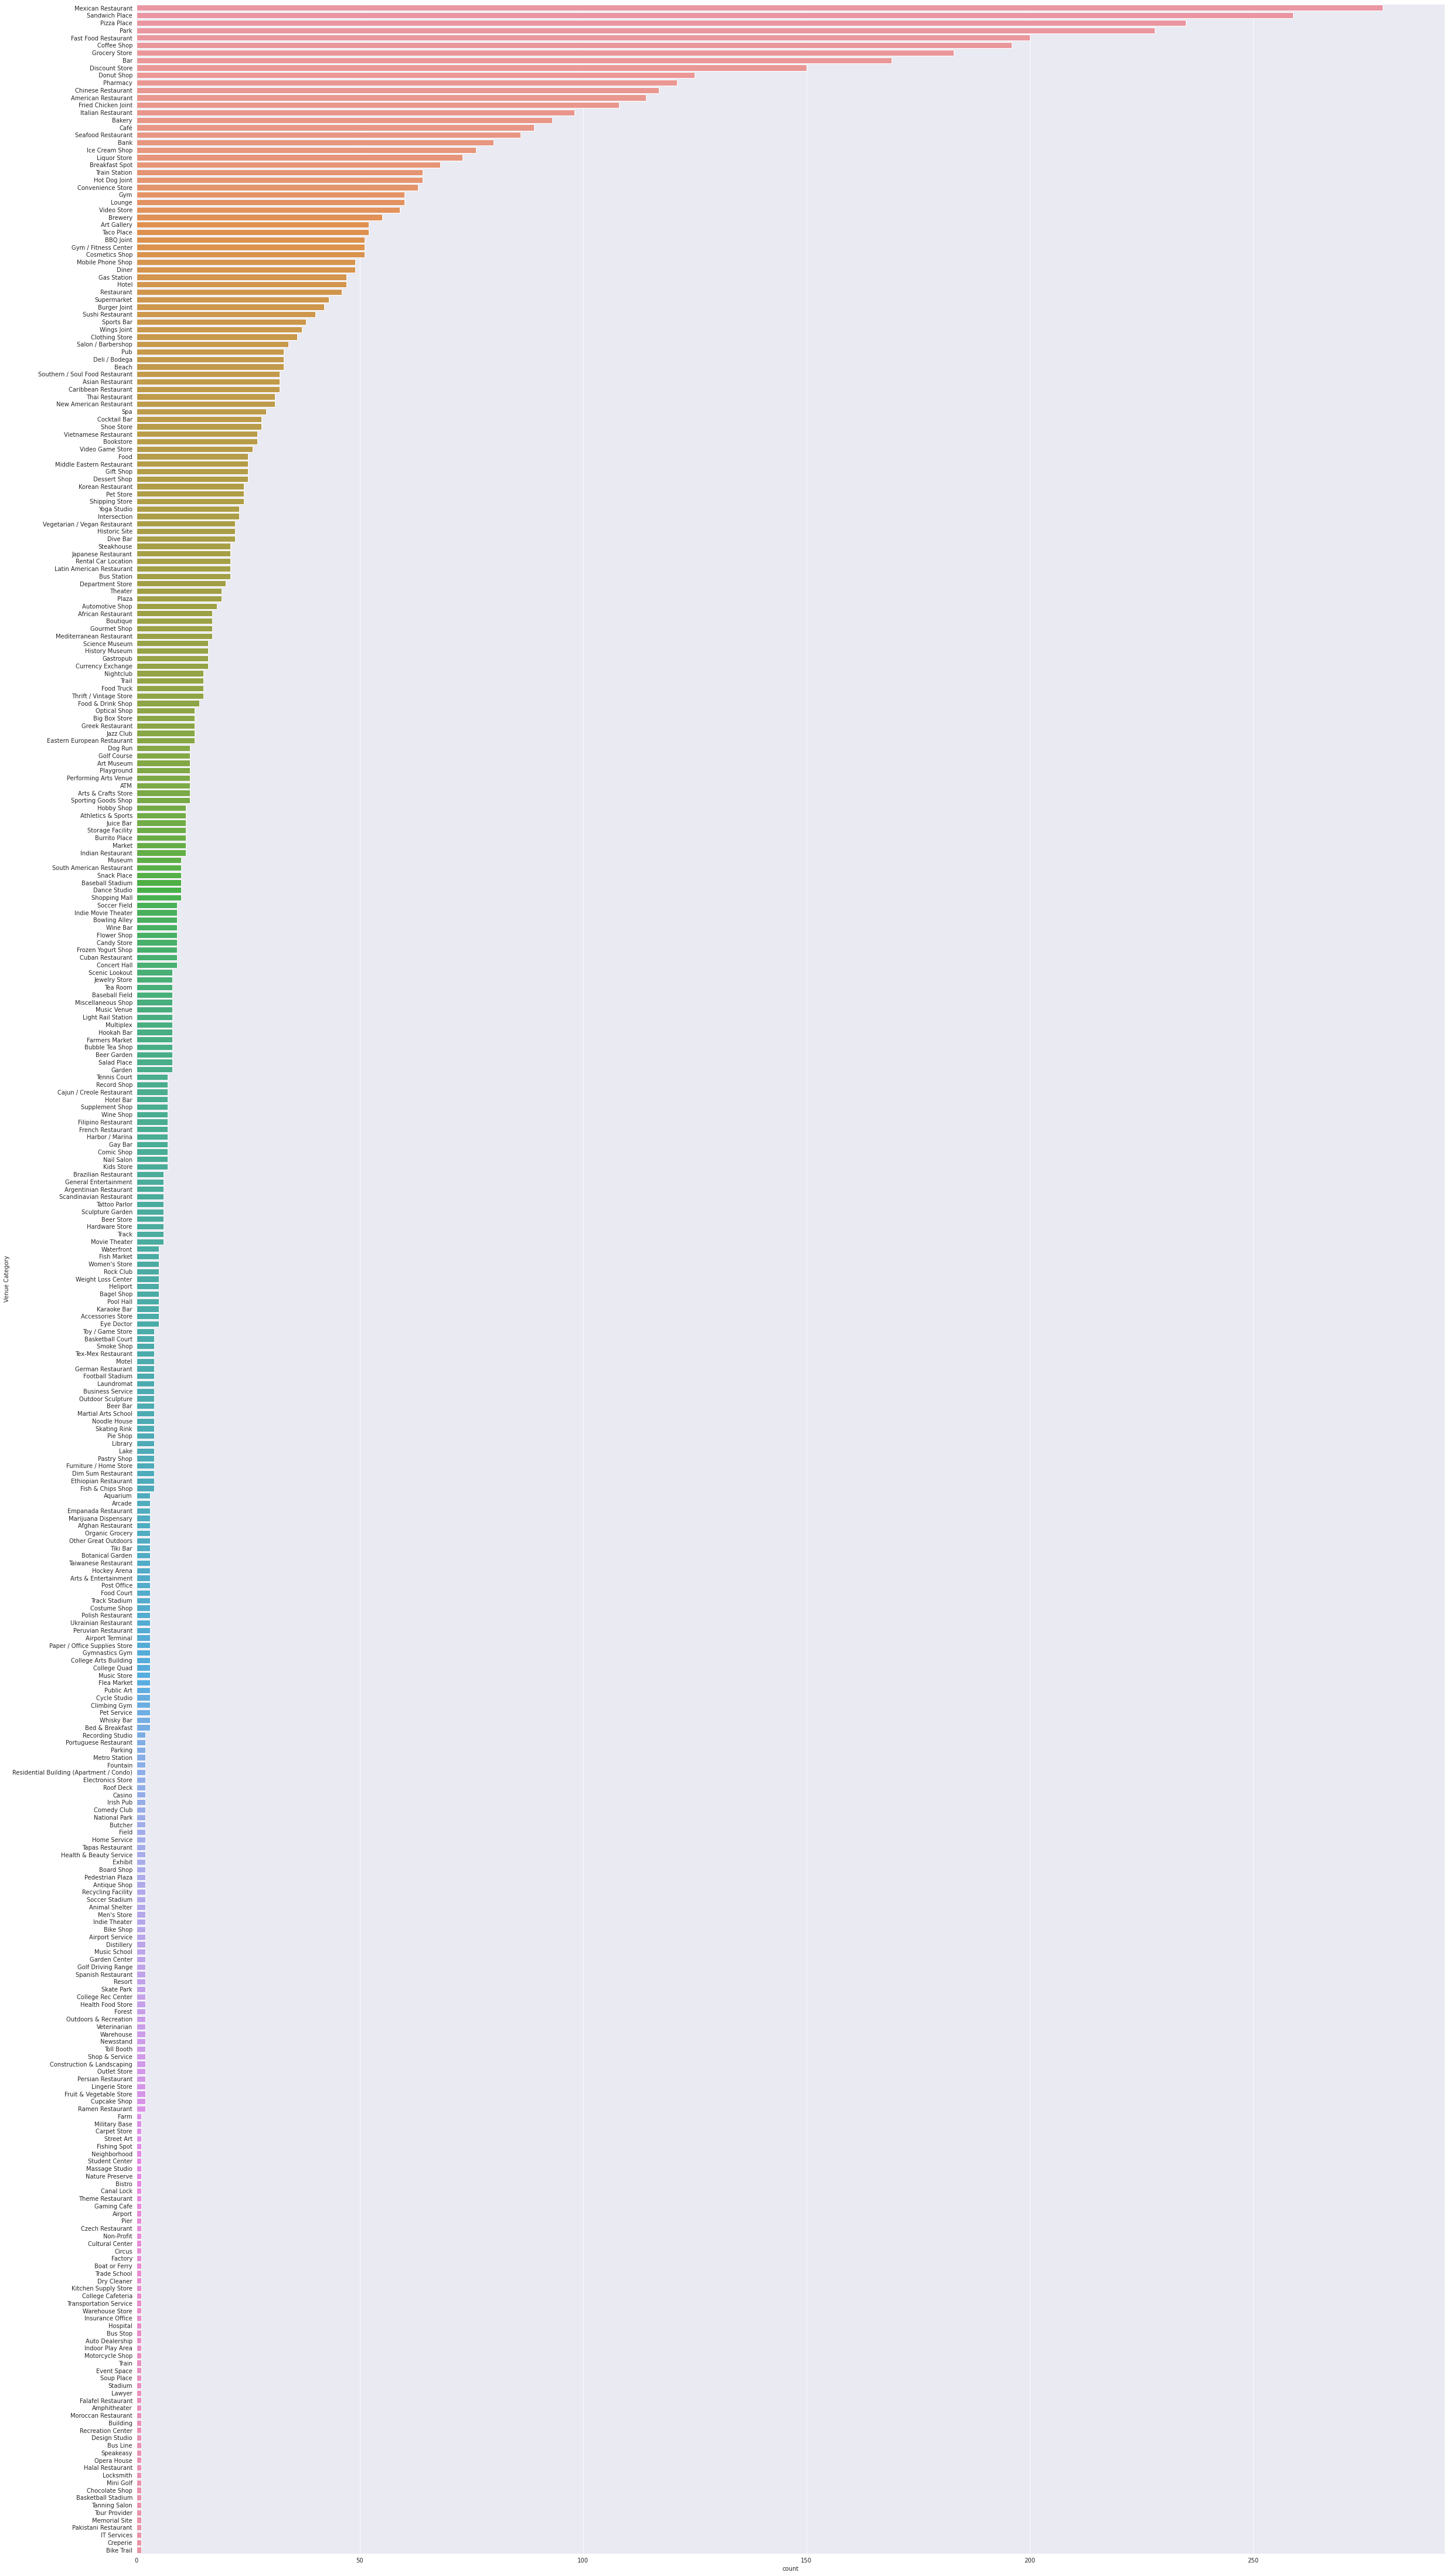

In [259]:
plt.figure(figsize=(40,80))
sns.countplot (y='Venue Category', data=chicago_venues_df,order=chicago_venues_df['Venue Category'].value_counts().index)

plt.show()

Due to there being many venue categories with a small amount of occurrences, the majority having 2 or less, it would be in our favor to generalize the categories into broader groups

#### Generalize Venue Categories

The FourSquare documentation contains a basic grouping of venue categories that can be leverage in order to create a more general grouping

In [260]:
URL = r'https://developer.foursquare.com/docs/build-with-foursquare/categories/'


page = requests.get(URL)
soup = BeautifulSoup(page.text, 'html.parser')

def get_sub_categories(foobar):
    sub_list = foobar.find('ul',  {'class': 'VenueCategories__Wrapper-sc-1ysxg0y-0 dikXMT'})
    sub_categories = [sub.find('h3').text for sub in sub_list.findAll('li', recursive=True)]
    return sub_categories

ul = soup.find('ul',  {'class': 'VenueCategories__Wrapper-sc-1ysxg0y-0 dikXMT'})
general_categories = ul.findAll('li', recursive=False)
general_venue_categories = {gen.find('h3').text: get_sub_categories(gen) for gen in general_categories}

general_venue_categories

{'Arts & Entertainment': ['Amphitheater',
  'Aquarium',
  'Arcade',
  'Art Gallery',
  'Bowling Alley',
  'Casino',
  'Circus',
  'Comedy Club',
  'Concert Hall',
  'Country Dance Club',
  'Disc Golf',
  'Exhibit',
  'General Entertainment',
  'Go Kart Track',
  'Historic Site',
  'Karaoke Box',
  'Laser Tag',
  'Memorial Site',
  'Mini Golf',
  'Movie Theater',
  'Drive-in Theater',
  'Indie Movie Theater',
  'Multiplex',
  'Museum',
  'Art Museum',
  'Erotic Museum',
  'History Museum',
  'Planetarium',
  'Science Museum',
  'Music Venue',
  'Jazz Club',
  'Piano Bar',
  'Rock Club',
  'Pachinko Parlor',
  'Performing Arts Venue',
  'Dance Studio',
  'Indie Theater',
  'Opera House',
  'Theater',
  'Pool Hall',
  'Public Art',
  'Outdoor Sculpture',
  'Street Art',
  'Racecourse',
  'Racetrack',
  'Roller Rink',
  'Salsa Club',
  'Samba School',
  'Stadium',
  'Baseball Stadium',
  'Basketball Stadium',
  'Cricket Ground',
  'Football Stadium',
  'Hockey Arena',
  'Rugby Stadium',
  

In [261]:
def get_general_venue_category(category):
    for k, i in general_venue_categories.items():
        if category in i: return k
    return "Misc"

for i, row in chicago_venues_df.iterrows():
    new_category = get_general_venue_category(row['Venue Category'])
#     print(row['Venue_Category'], '-->', new_category)
    chicago_venues_df.loc[i, 'Venue Category'] = get_general_venue_category(row['Venue Category'])

chicago_venues_df['Venue Category'].value_counts()

Food                           3207
Shop & Service                 1601
Outdoors & Recreation           596
Nightlife Spot                  475
Arts & Entertainment            299
Travel & Transport              214
Misc                             36
Professional & Other Places      31
College & University             11
Residence                         2
Name: Venue Category, dtype: int64

Drop Misc Venue Categories

In [262]:
chicago_venues_df.drop(chicago_venues_df[chicago_venues_df['Venue Category'] == 'Misc'].index, inplace=True)

In [263]:
chicago_venues_df['Venue Category'].value_counts()

Food                           3207
Shop & Service                 1601
Outdoors & Recreation           596
Nightlife Spot                  475
Arts & Entertainment            299
Travel & Transport              214
Professional & Other Places      31
College & University             11
Residence                         2
Name: Venue Category, dtype: int64

### 6.Preparing data for clustering
#### 6.1 Enchoding the dataframe and prepare for clustering analysis

In [264]:
# one hot encoding of Venue Category
chicago_onehot=pd.get_dummies(chicago_venues_df[['Venue Category']],prefix="", prefix_sep="")

# add Neighborhood column back to the dataframe
chicago_onehot['Neighborhood']=chicago_venues_df['Neighborhood']

#move Neighborhood column to the first column

fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]
chicago_onehot.head()

,Neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Rogers Park,0,0,1,0,0,0,0,0,0
1,Rogers Park,0,0,0,0,0,0,0,1,0
2,Rogers Park,0,0,0,0,0,0,0,1,0
3,Rogers Park,0,0,1,0,0,0,0,0,0
4,Rogers Park,0,0,0,0,0,0,0,1,0


In [265]:
# Number of venues encoded
print('{} venues encoded.'.format(chicago_onehot.shape[0]-1))
# Shape of encoded dataframe
print('Shape chicago_onehot:', chicago_onehot.shape)

6435 venues encoded.
Shape chicago_onehot: (6436, 10)


#### 6.2 Group rows by neighborhood and by taking the mean of the frequency of occurrence of each venue category

In [266]:
chicago_grouped = chicago_onehot.groupby('Neighborhood').mean().reset_index()
chicago_grouped.head()

,Neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Albany Park,0.010000,0.0,0.650000,0.080000,0.100000,0.00,0.0,0.160000,0.000000
1,Archer Heights,0.000000,0.0,0.420000,0.040000,0.040000,0.00,0.0,0.460000,0.040000
2,Armour Square,0.080000,0.0,0.620000,0.100000,0.080000,0.01,0.0,0.100000,0.010000
3,Ashburn,0.039474,0.0,0.460526,0.039474,0.144737,0.00,0.0,0.263158,0.052632
4,Auburn Gresham,0.012658,0.0,0.468354,0.139241,0.037975,0.00,0.0,0.291139,0.050633


In [267]:
# check food venue category frequency
chicago_grouped.groupby(['Neighborhood','Food']).sum()

,,Arts & Entertainment,College & University,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
Neighborhood,Food,,,,,,,,
Albany Park,0.650000,0.010000,0.000000,0.080000,0.100000,0.000000,0.0,0.160000,0.000000
Archer Heights,0.420000,0.000000,0.000000,0.040000,0.040000,0.000000,0.0,0.460000,0.040000
Armour Square,0.620000,0.080000,0.000000,0.100000,0.080000,0.010000,0.0,0.100000,0.010000
Ashburn,0.460526,0.039474,0.000000,0.039474,0.144737,0.000000,0.0,0.263158,0.052632
Auburn Gresham,0.468354,0.012658,0.000000,0.139241,0.037975,0.000000,0.0,0.291139,0.050633
...,...,...,...,...,...,...,...,...,...
West Garfield Park,0.444444,0.022222,0.000000,0.044444,0.111111,0.000000,0.0,0.244444,0.133333
West Lawn,0.523810,0.059524,0.000000,0.011905,0.023810,0.011905,0.0,0.250000,0.119048
West Pullman,0.466667,0.033333,0.000000,0.033333,0.066667,0.000000,0.0,0.366667,0.033333


In [268]:
chicago_grouped.shape

(76, 10)

In [269]:
neighborhood_venues_freq = chicago_grouped.groupby('Neighborhood').mean().reset_index()
# Set Index as Neighborhood
neighborhood_venues_freq.set_index('Neighborhood', inplace=True)
neighborhood_venues_freq

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
Neighborhood,,,,,,,,,
Albany Park,0.010000,0.000000,0.650000,0.080000,0.100000,0.000000,0.0,0.160000,0.000000
Archer Heights,0.000000,0.000000,0.420000,0.040000,0.040000,0.000000,0.0,0.460000,0.040000
Armour Square,0.080000,0.000000,0.620000,0.100000,0.080000,0.010000,0.0,0.100000,0.010000
Ashburn,0.039474,0.000000,0.460526,0.039474,0.144737,0.000000,0.0,0.263158,0.052632
Auburn Gresham,0.012658,0.000000,0.468354,0.139241,0.037975,0.000000,0.0,0.291139,0.050633
...,...,...,...,...,...,...,...,...,...
West Garfield Park,0.022222,0.000000,0.444444,0.044444,0.111111,0.000000,0.0,0.244444,0.133333
West Lawn,0.059524,0.000000,0.523810,0.011905,0.023810,0.011905,0.0,0.250000,0.119048
West Pullman,0.033333,0.000000,0.466667,0.033333,0.066667,0.000000,0.0,0.366667,0.033333


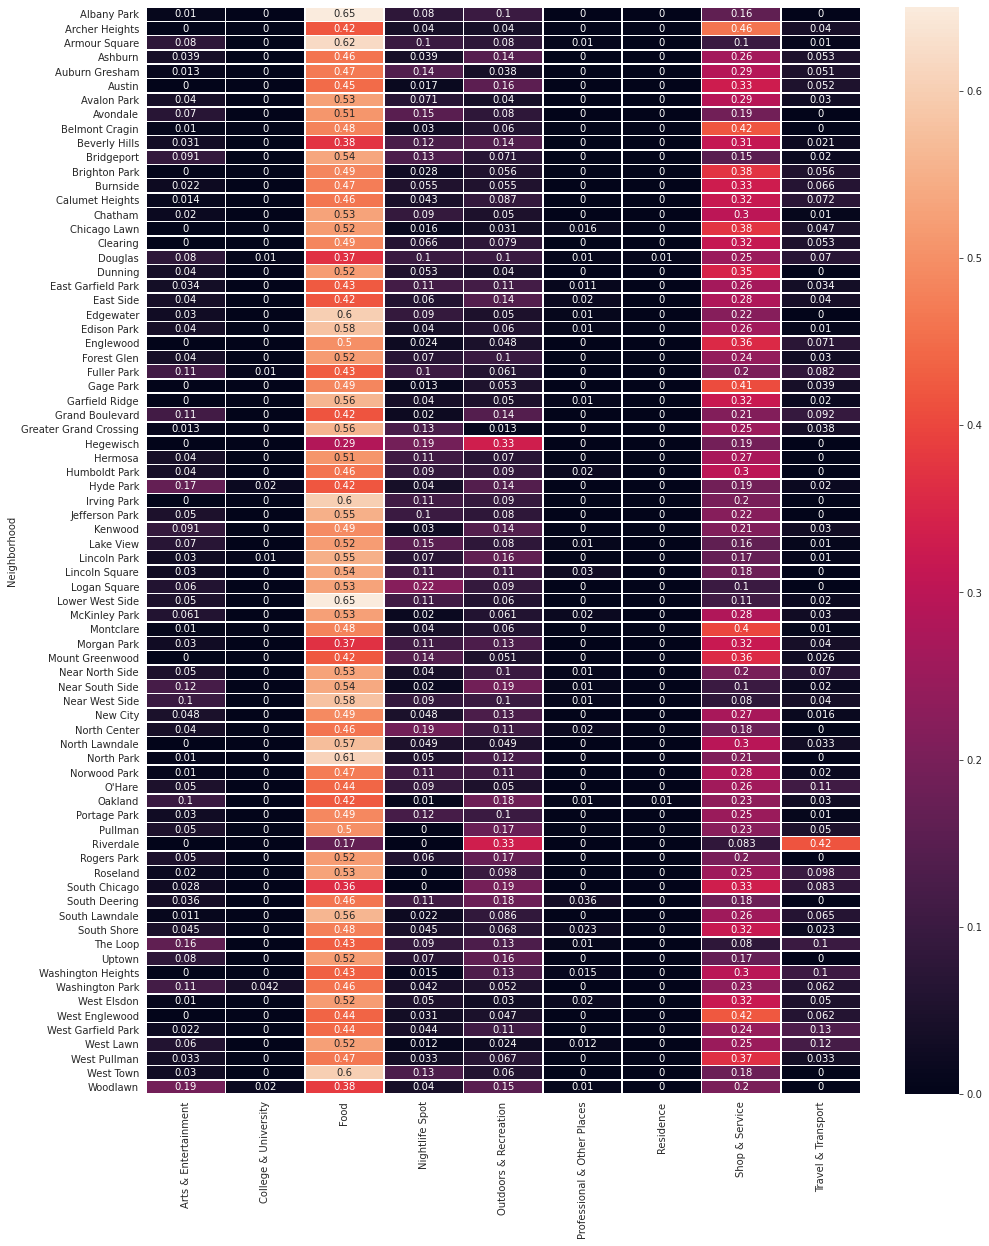

In [270]:
# visualize the venue category frequency
fig, ax = plt.subplots(figsize=(16, 20))
sns.heatmap(ax=ax, data=neighborhood_venues_freq, annot=True, linewidths=.5, square=False)
plt.show()

### 7. Processing the demographic data

Obtain the population data

In [271]:
chicago_demographics=chicago_data[["Neighborhood","2017 Population"]]
chicago_demographics.head()

,Neighborhood,2017 Population
0,Rogers Park,55062
1,Uptown,57973
2,Lincoln Square,41715
3,North Center,35789
4,Lake View,100470


Load the income per capita data

In [272]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_98d0dd401bd24bb9a71726fbdb13b7fa = 'https://s3-api.us-geo.objectstorage.softlayer.net'
else:
    endpoint_98d0dd401bd24bb9a71726fbdb13b7fa = 'https://s3-api.us-geo.objectstorage.service.networklayer.com'

client_98d0dd401bd24bb9a71726fbdb13b7fa = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='P47oYhq-5prsGz-IRkYsD6HgxNaWSsiG6vnLqKzm8RqE',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_98d0dd401bd24bb9a71726fbdb13b7fa)

body = client_98d0dd401bd24bb9a71726fbdb13b7fa.get_object(Bucket='pythonbasicsfordatascienceproject-donotdelete-pr-clecqjwbrbwjns',Key='Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

chicago_demographics2 = pd.read_csv(body)
chicago_demographics2.head()


,Community Area Number,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0
2,3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0
3,4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0
4,5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0


In [273]:
# Get only the neiborhood name and income per capita
chicago_demographics3=chicago_demographics2[['COMMUNITY AREA NAME','PER CAPITA INCOME ']]
chicago_demographics3.rename(columns={'COMMUNITY AREA NAME':"Neighborhood"},inplace=True)
chicago_demographics3.set_index('Neighborhood',inplace=True)
chicago_demographics3

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PER CAPITA INCOME
Neighborhood,
Rogers Park,23939
West Ridge,23040
Uptown,35787
Lincoln Square,37524
North Center,57123
...,...
Mount Greenwood,34381
Morgan Park,27149
O'Hare,25828


Creat a new datafram with the data needed for analysis

In [274]:
# merge the income per capita with total population
chicago_demo = chicago_data.set_index('Neighborhood')
#add intalian restaurant in the clustering
chicago_demo = chicago_demo.join(chicago_demographics3,on='Neighborhood')
chicago_demo.head()

,2017 Population,Latitude,Longitude,PER CAPITA INCOME
Neighborhood,,,,
Rogers Park,55062,42.009037,-87.676849,23939.0
Uptown,57973,41.966630,-87.655546,35787.0
Lincoln Square,41715,41.968512,-87.688653,37524.0
North Center,35789,41.956107,-87.679160,57123.0
Lake View,100470,41.943919,-87.654076,60058.0


Scale demographic data

In [275]:
chicago_demo_scaled=chicago_demo.copy()

In [276]:
chicago_demo_scaled.drop(['Latitude','Longitude'],1,inplace=True)

In [277]:
min_max_scaler = MinMaxScaler()

chicago_demo_scaled[['2017 Population', 'PER CAPITA INCOME ']] = min_max_scaler.fit_transform(chicago_demo_scaled[['2017 Population', 'PER CAPITA INCOME ']])

chicago_demo_scaled.head()

,2017 Population,PER CAPITA INCOME
Neighborhood,,
Rogers Park,0.537672,0.195581
Uptown,0.567311,0.342820
Lincoln Square,0.401778,0.364406
North Center,0.341441,0.607968
Lake View,1.000000,0.644443


### 8.  Merge the Venue Category Frequency with the neighborhood Demographics

In [278]:
clustering_data = chicago_demo_scaled.join(neighborhood_venues_freq,on='Neighborhood')
clustering_data.fillna(0, inplace=True)
# Drop Neighborhood Index
clustering_data

,2017 Population,PER CAPITA INCOME,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
Neighborhood,,,,,,,,,,,
Rogers Park,0.537672,0.195581,0.050000,0.0,0.520000,0.060000,0.170000,0.000000,0.0,0.200000,0.000000
Uptown,0.567311,0.342820,0.080000,0.0,0.520000,0.070000,0.160000,0.000000,0.0,0.170000,0.000000
Lincoln Square,0.401778,0.364406,0.030303,0.0,0.535354,0.111111,0.111111,0.030303,0.0,0.181818,0.000000
North Center,0.341441,0.607968,0.040000,0.0,0.460000,0.190000,0.110000,0.020000,0.0,0.180000,0.000000
Lake View,1.000000,0.644443,0.070000,0.0,0.520000,0.150000,0.080000,0.010000,0.0,0.160000,0.010000
...,...,...,...,...,...,...,...,...,...,...,...
Washington Heights,0.256567,0.000000,0.000000,0.0,0.432836,0.014925,0.134328,0.014925,0.0,0.298507,0.104478
Mount Greenwood,0.173322,0.325347,0.000000,0.0,0.423077,0.141026,0.051282,0.000000,0.0,0.358974,0.025641
Morgan Park,0.205058,0.235472,0.030000,0.0,0.370000,0.110000,0.130000,0.000000,0.0,0.320000,0.040000


In [279]:
clustering_data.describe()

,2017 Population,PER CAPITA INCOME,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,0.331468,0.196629,0.042291,0.001475,0.488729,0.070091,0.099075,0.004778,0.000264,0.253135,0.040162
std,0.230167,0.187746,0.041977,0.005981,0.078553,0.049014,0.059025,0.008106,0.001620,0.086169,0.055076
min,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.012658,0.000000,0.000000,0.080000,0.000000
25%,0.170245,0.077782,0.010000,0.000000,0.443333,0.032813,0.055403,0.000000,0.000000,0.197619,0.007500
50%,0.273296,0.138241,0.033908,0.000000,0.491032,0.057473,0.088478,0.000000,0.000000,0.254033,0.030303
75%,0.437049,0.238275,0.052381,0.000000,0.530000,0.107857,0.131082,0.010000,0.000000,0.316388,0.053363
max,1.000000,1.000000,0.191919,0.041667,0.650000,0.220000,0.333333,0.035714,0.010101,0.460000,0.416667


## 9. Kmeans Clustering

Determine the Number of Cluster (Elbow Method)

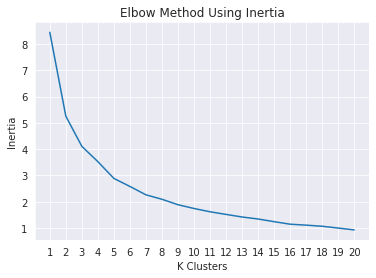

In [280]:
# drop Neighborhood
chicago_clustered=clustering_data.reset_index(drop=True)

# apply Elbow Method
max_clusters = 20

inertias = []
for k in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(chicago_clustered)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, max_clusters+1), inertias)
plt.title("Elbow Method Using Inertia")
plt.ylabel("Inertia")
plt.xlabel("K Clusters")
plt.xticks(ticks=range(1, max_clusters+1))
plt.show()

Base on the elbow method, 6 is determined to be the optimal number of cluster

In [281]:
kclusters = 5

Run Kmeans clustering

In [282]:
# run Kmeans clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, n_init=10).fit(chicago_clustered)

Create a dataframe to include cluaster

In [283]:
# add clustering labels
neighborhood_venues_freq.insert(0, 'Cluster Labels', kmeans.labels_)

In [284]:
chicago_neighborhoods_clusters = chicago_demo
#add intalian restaurant in the clustering
chicago_neighborhoods_clusters = chicago_neighborhoods_clusters.join(nearby_pizza_count,on='Neighborhood')

# merge chicago_grouped with chicago_rest_data to add latitude/longitude for each neighborhood
chicago_neighborhoods_clusters = chicago_neighborhoods_clusters.join(neighborhood_venues_freq, on='Neighborhood')

#fill empty value with 0
chicago_neighborhoods_clusters.fillna(0, inplace=True)

chicago_neighborhoods_clusters.head() # check the last columns!

,2017 Population,Latitude,Longitude,PER CAPITA INCOME,Pizza Place Count,Cluster Labels,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
Neighborhood,,,,,,,,,,,,,,,
Rogers Park,55062,42.009037,-87.676849,23939.0,5.0,4,0.050000,0.0,0.520000,0.060000,0.170000,0.000000,0.0,0.200000,0.00
Uptown,57973,41.966630,-87.655546,35787.0,4.0,4,0.080000,0.0,0.520000,0.070000,0.160000,0.000000,0.0,0.170000,0.00
Lincoln Square,41715,41.968512,-87.688653,37524.0,5.0,3,0.030303,0.0,0.535354,0.111111,0.111111,0.030303,0.0,0.181818,0.00
North Center,35789,41.956107,-87.679160,57123.0,4.0,1,0.040000,0.0,0.460000,0.190000,0.110000,0.020000,0.0,0.180000,0.00
Lake View,100470,41.943919,-87.654076,60058.0,5.0,3,0.070000,0.0,0.520000,0.150000,0.080000,0.010000,0.0,0.160000,0.01


In [285]:
chicago_neighborhoods_clusters.reset_index(inplace=True)

Check the cluster result

In [286]:
# create map
map_clusters = folium.Map(location=[chicago_latitude, chicago_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_neighborhoods_clusters['Latitude'], chicago_neighborhoods_clusters['Longitude'], chicago_neighborhoods_clusters['Neighborhood'], chicago_neighborhoods_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 10. Explore the cluster

In [287]:
clusters = []
for cluster in range(kclusters):
    clusters.append(chicago_neighborhoods_clusters.loc[chicago_neighborhoods_clusters['Cluster Labels'] == cluster])

Cluster 0

In [288]:
clusters[0]

,Neighborhood,2017 Population,Latitude,Longitude,PER CAPITA INCOME,Pizza Place Count,Cluster Labels,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
7,Edison Park,11605,42.004353,-87.812835,40959.0,3.0,0,0.040000,0.000000,0.580000,0.040000,0.060000,0.010000,0.00,0.260000,0.010000
12,Albany Park,51992,41.970329,-87.715992,21323.0,3.0,0,0.010000,0.000000,0.650000,0.080000,0.100000,0.000000,0.00,0.160000,0.000000
33,Douglas,20781,41.834868,-87.618013,23791.0,4.0,0,0.080000,0.010000,0.370000,0.100000,0.100000,0.010000,0.01,0.250000,0.070000
36,Grand Boulevard,22313,41.813923,-87.617272,23472.0,1.0,0,0.112245,0.000000,0.418367,0.020408,0.142857,0.000000,0.00,0.214286,0.091837
40,Woodlawn,23268,41.779479,-87.599493,18672.0,2.0,0,0.191919,0.020202,0.383838,0.040404,0.151515,0.010101,0.00,0.202020,0.000000
42,Chatham,31120,41.741145,-87.612548,18881.0,2.0,0,0.020000,0.000000,0.530000,0.090000,0.050000,0.000000,0.00,0.300000,0.010000
45,Burnside,2254,41.730035,-87.596714,12515.0,2.0,0,0.021978,0.000000,0.472527,0.054945,0.054945,0.000000,0.00,0.329670,0.065934
46,Calumet Heights,13188,41.730035,-87.579213,28887.0,2.0,0,0.014493,0.000000,0.463768,0.043478,0.086957,0.000000,0.00,0.318841,0.072464
50,East Side,23737,41.694618,-87.533387,17104.0,1.0,0,0.040000,0.000000,0.420000,0.060000,0.140000,0.020000,0.00,0.280000,0.040000
55,Archer Heights,13142,41.811422,-87.726165,16134.0,4.0,0,0.000000,0.000000,0.420000,0.040000,0.040000,0.000000,0.00,0.460000,0.040000


In [289]:
clusters[1]

,Neighborhood,2017 Population,Latitude,Longitude,PER CAPITA INCOME,Pizza Place Count,Cluster Labels,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
3,North Center,35789,41.956107,-87.679160,57123.0,4.0,1,0.040000,0.000000,0.460000,0.190000,0.110000,0.020000,0.000000,0.180000,0.000000
5,Lincoln Park,67710,41.939945,-87.636120,71551.0,3.0,1,0.030000,0.010000,0.550000,0.070000,0.160000,0.000000,0.000000,0.170000,0.010000
6,Near North Side,88893,41.900033,-87.634497,88669.0,3.0,1,0.050000,0.000000,0.530000,0.040000,0.100000,0.010000,0.000000,0.200000,0.070000
8,Norwood Park,37089,41.988066,-87.802749,32875.0,2.0,1,0.010000,0.000000,0.470000,0.110000,0.110000,0.000000,0.000000,0.280000,0.020000
9,Jefferson Park,26808,41.969738,-87.763118,27751.0,4.0,1,0.050000,0.000000,0.550000,0.100000,0.080000,0.000000,0.000000,0.220000,0.000000
10,Forest Glen,19019,41.985493,-87.754681,44164.0,4.0,1,0.040000,0.000000,0.520000,0.070000,0.100000,0.000000,0.000000,0.240000,0.030000
11,North Park,18842,41.980587,-87.720892,26576.0,5.0,1,0.010000,0.000000,0.610000,0.050000,0.120000,0.000000,0.000000,0.210000,0.000000
14,Irving Park,54606,41.953365,-87.736447,27249.0,4.0,1,0.000000,0.000000,0.600000,0.110000,0.090000,0.000000,0.000000,0.200000,0.000000
15,Dunning,43689,41.952809,-87.796449,26282.0,4.0,1,0.040000,0.000000,0.520000,0.053333,0.040000,0.000000,0.000000,0.346667,0.000000
16,Montclare,13830,41.925309,-87.800893,0.0,6.0,1,0.010000,0.000000,0.480000,0.040000,0.060000,0.000000,0.000000,0.400000,0.010000


In [290]:
clusters[2]

,Neighborhood,2017 Population,Latitude,Longitude,PER CAPITA INCOME,Pizza Place Count,Cluster Labels,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
23,Austin,95260,41.888032,-87.764864,15957.0,1.0,2,0.000000,0.0,0.448276,0.017241,0.155172,0.0,0.0,0.327586,0.051724
43,Avalon Park,9985,41.745035,-87.588658,24454.0,2.0,2,0.040404,0.0,0.525253,0.070707,0.040404,0.0,0.0,0.292929,0.030303
69,Auburn Gresham,46278,41.743167,-87.653728,15528.0,1.0,2,0.012658,0.0,0.468354,0.139241,0.037975,0.0,0.0,0.291139,0.050633


In [291]:
clusters[3]

,Neighborhood,2017 Population,Latitude,Longitude,PER CAPITA INCOME,Pizza Place Count,Cluster Labels,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
2,Lincoln Square,41715,41.968512,-87.688653,37524.0,5.0,3,0.030303,0.0,0.535354,0.111111,0.111111,0.030303,0.0,0.181818,0.000000
4,Lake View,100470,41.943919,-87.654076,60058.0,5.0,3,0.070000,0.0,0.520000,0.150000,0.080000,0.010000,0.0,0.160000,0.010000
17,Belmont Cragin,79910,41.930848,-87.768949,15461.0,2.0,3,0.010000,0.0,0.480000,0.030000,0.060000,0.000000,0.0,0.420000,0.000000
18,Hermosa,24144,41.928643,-87.734502,15089.0,3.0,3,0.040000,0.0,0.510000,0.110000,0.070000,0.000000,0.0,0.270000,0.000000
19,Avondale,37368,41.938921,-87.711168,20039.0,1.0,3,0.070000,0.0,0.510000,0.150000,0.080000,0.000000,0.0,0.190000,0.000000
32,Armour Square,13455,41.840231,-87.632986,16148.0,4.0,3,0.080000,0.0,0.620000,0.100000,0.080000,0.010000,0.0,0.100000,0.010000
56,Brighton Park,44813,41.818922,-87.698942,13089.0,3.0,3,0.000000,0.0,0.486111,0.027778,0.055556,0.000000,0.0,0.375000,0.055556
58,Bridgeport,33637,41.837938,-87.651028,22694.0,6.0,3,0.090909,0.0,0.535354,0.131313,0.070707,0.000000,0.0,0.151515,0.020202
63,West Lawn,33108,41.772811,-87.722275,16907.0,5.0,3,0.059524,0.0,0.523810,0.011905,0.023810,0.011905,0.0,0.250000,0.119048
68,Ashburn,43792,41.747533,-87.711163,23482.0,3.0,3,0.039474,0.0,0.460526,0.039474,0.144737,0.000000,0.0,0.263158,0.052632


In [292]:
clusters[4]

,Neighborhood,2017 Population,Latitude,Longitude,PER CAPITA INCOME,Pizza Place Count,Cluster Labels,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Rogers Park,55062,42.009037,-87.676849,23939.0,5.0,4,0.050000,0.000000,0.520000,0.060000,0.170000,0.000000,0.0,0.200000,0.000000
1,Uptown,57973,41.966630,-87.655546,35787.0,4.0,4,0.080000,0.000000,0.520000,0.070000,0.160000,0.000000,0.0,0.170000,0.000000
13,Portage Park,64307,41.957809,-87.765059,24336.0,4.0,4,0.030000,0.000000,0.490000,0.120000,0.100000,0.000000,0.0,0.250000,0.010000
25,East Garfield Park,19996,41.880866,-87.702833,12961.0,1.0,4,0.034483,0.000000,0.425287,0.114943,0.114943,0.011494,0.0,0.264368,0.034483
27,North Lawndale,35947,41.860032,-87.718388,12034.0,3.0,4,0.000000,0.000000,0.573770,0.049180,0.049180,0.000000,0.0,0.295082,0.032787
28,South Lawndale,74851,41.843644,-87.712554,10402.0,4.0,4,0.010753,0.000000,0.559140,0.021505,0.086022,0.000000,0.0,0.258065,0.064516
29,Lower West Side,32888,41.854200,-87.665609,16444.0,3.0,4,0.050000,0.000000,0.650000,0.110000,0.060000,0.000000,0.0,0.110000,0.020000
30,The Loop,35880,41.881609,-87.629457,0.0,3.0,4,0.160000,0.000000,0.430000,0.090000,0.130000,0.010000,0.0,0.080000,0.100000
31,Near South Side,23620,41.856700,-87.624774,59077.0,5.0,4,0.120000,0.000000,0.540000,0.020000,0.190000,0.010000,0.0,0.100000,0.020000
38,Washington Park,11502,41.792534,-87.618105,13785.0,1.0,4,0.114583,0.041667,0.458333,0.041667,0.052083,0.000000,0.0,0.229167,0.062500


In [293]:
chicago_neighborhoods_clusters[['Cluster Labels', 'Pizza Place Count']].groupby('Cluster Labels').sum()

,Pizza Place Count
Cluster Labels,
0,28.0
1,85.0
2,4.0
3,43.0
4,75.0


Explore attributes of each cluster

In [294]:
clusters_df = chicago_neighborhoods_clusters.groupby('Cluster Labels').mean().reset_index()
clusters_df['Pizza Place Count'] = chicago_neighborhoods_clusters[['Cluster Labels', 'Pizza Place Count']].groupby('Cluster Labels').sum()
clusters_df

,Cluster Labels,2017 Population,Latitude,Longitude,PER CAPITA INCOME,Pizza Place Count,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0,23279.000000,41.807083,-87.646140,20483.083333,28.0,0.044220,0.002517,0.474612,0.050517,0.085544,0.004175,0.000833,0.294988,0.042595
1,1,35823.148148,41.856071,-87.689034,29757.222222,85.0,0.043961,0.001489,0.495473,0.074787,0.100717,0.002596,0.000374,0.248988,0.031614
2,2,50507.666667,41.792078,-87.669084,18646.333333,4.0,0.017687,0.000000,0.480628,0.075730,0.077850,0.000000,0.000000,0.303885,0.044220
3,3,43021.272727,41.857013,-87.694866,21862.818182,43.0,0.047405,0.000000,0.505105,0.089689,0.082849,0.005655,0.000000,0.243090,0.026206
4,4,33660.521739,41.827634,-87.663349,19091.086957,75.0,0.040088,0.001812,0.481402,0.064683,0.114736,0.007856,0.000000,0.234351,0.055071


Identify the Neighborhoods in the cluster with the most nearby food trucks

In [295]:
solution_cluster = clusters[1]
list(solution_cluster['Neighborhood'])

['North Center',
 'Lincoln Park',
 'Near North Side',
 'Norwood Park',
 'Jefferson Park',
 'Forest Glen',
 'North Park',
 'Irving Park',
 'Dunning',
 'Montclare',
 'Logan Square',
 'Humboldt Park',
 'West Town',
 'West Garfield Park',
 'Near West Side',
 'Oakland',
 'Fuller Park',
 'Kenwood',
 'Hyde Park',
 'Roseland',
 'Pullman',
 'West Pullman',
 'New City',
 'Clearing',
 'West Englewood',
 'Mount Greenwood',
 'Morgan Park']

In [298]:
nearby_italian_count.index
potential_solutions = solution_cluster.loc[~solution_cluster['Neighborhood'].isin(nearby_pizza_count.index)]
potential_solutions

,Neighborhood,2017 Population,Latitude,Longitude,PER CAPITA INCOME,Pizza Place Count,Cluster Labels,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
24,West Garfield Park,17163,41.880588,-87.729223,10934.0,0.0,1,0.022222,0.0,0.444444,0.044444,0.111111,0.0,0.0,0.244444,0.133333
48,Pullman,6613,41.692218,-87.606604,20588.0,0.0,1,0.050000,0.0,0.500000,0.000000,0.175000,0.0,0.0,0.225000,0.050000
65,West Englewood,29929,41.778089,-87.666718,11317.0,0.0,1,0.000000,0.0,0.437500,0.031250,0.046875,0.0,0.0,0.421875,0.062500


In [297]:
_corr = clusters_df.corr()
_corr["Pizza Place Count"].sort_values(ascending=False)

Pizza Place Count              1.000000
Outdoors & Recreation          0.858319
Latitude                       0.745358
PER CAPITA INCOME              0.639434
Arts & Entertainment           0.625226
Professional & Other Places    0.544202
College & University           0.396066
Food                           0.361226
Cluster Labels                 0.246393
Nightlife Spot                 0.040226
Residence                     -0.032888
Travel & Transport            -0.047823
Longitude                     -0.352506
2017 Population               -0.353076
Shop & Service                -0.848639
Name: Pizza Place Count, dtype: float64

## D. Discussion

As mentioned the purpose of this project was to explore Chicagao neighborhoods in order to find neighborhoods that could provide potentially successful pizza place locations. In order to determine possible solution neighborhoods, we use the K-means clustering algorithm to cluster the neighborhoods based on their basic demographics and types or categories of nearby venues.

After the clustering, we can assume that if a single cluster has a much greater number of nearby pizza places in comparison to the other clusters, then the cluster has attributes that are favorable to pizza places.

Comparing the feature of each cluster can give us also provide us with an understanding of what features a neighborhood needs in order to be potentially successful pizza place location.

As a result of the clustering it can determined that there are three neighborhoods that provide a good solution West Garfield Park, Pullman,and West Englewood.

## F. Conclusion
In this project, I analyzed Chicago neighborhoods in order to determine potential new neighborhoods for pizza place venues. I build a clustering model that groups neighborhoods base on their demographics as well as categories of nearby venues. The clusters can be useful in determining features that different neighborhoods. Additionally, the clustering can be used to determined features that make preferable pizza place locations.